# Hybrid Pit Stop Strategy Advisor (HPSSA)

Sistem kecerdasan buatan untuk memberikan rekomendasi strategi pit stop pada balapan Formula 1. Sistem ini menggunakan pendekatan **hybrid** dengan menggabungkan tiga paradigma AI yang berbeda untuk menghasilkan keputusan yang komprehensif.

## Arsitektur Sistem

- **Modul 1 - Fuzzy Logic**: Menganalisis kondisi ban dan cuaca → menghasilkan skor urgensi (0-10)
- **Modul 2 - Bayesian Network**: Memprediksi probabilitas Safety Car → menghasilkan probabilitas SC (0-1)
- **Modul 3 - First-Order Logic**: Memvalidasi strategi terhadap regulasi FIA → menghasilkan status Valid/Invalid
- **Modul 4 - Decision Engine**: Simulasi balapan dengan data FastF1 → menghasilkan rekomendasi per lap
- **Modul 5 - Real-time Interface**: Input manual dengan weather API → menghasilkan rekomendasi real-time

## Alur Kerja

1. Input kondisi balapan (ban, cuaca, trek)
2. Modul 1 menghitung skor urgensi
3. Modul 2 menghitung risiko Safety Car
4. Modul 3 memvalidasi strategi terhadap regulasi
5. Sistem menghasilkan keputusan: **BOX** atau **STAY OUT**

In [62]:
import sys
import os
import logging
import warnings

import numpy as np
import pandas as pd
import requests

import matplotlib.pyplot as plt
import seaborn as sns

import skfuzzy as fuzz
from skfuzzy import control as ctrl
import networkx as nx
import fastf1

warnings.filterwarnings('ignore')
logging.getLogger('fastf1').setLevel(logging.ERROR)

aima_path = os.path.abspath('Logical Agents')
if aima_path not in sys.path:
    sys.path.append(aima_path)
from logic import FolKB, expr

CACHE_DIR = 'fastf1_cache'
os.makedirs(CACHE_DIR, exist_ok=True)
fastf1.Cache.enable_cache(CACHE_DIR)

COMPOUND_MAP = {'SOFT': 7, 'MEDIUM': 5, 'HARD': 3, 'INTERMEDIATE': 9, 'INTER': 9, 'WET': 10}
THRESHOLD_CRITICAL = 7.5
THRESHOLD_STRATEGIC = 4.5

circuits_df = pd.read_csv('circuit coordinate.csv')
CIRCUIT_COORDS = dict(zip(circuits_df['Venue'], zip(circuits_df['Latitude'], circuits_df['Longitude'])))

print("Setup complete. All modules imported successfully.")

Setup complete. All modules imported successfully.


---
## Modul 1: Fuzzy Logic (Penganalisis Kondisi)

Modul ini menggunakan **Fuzzy Inference System** untuk menghitung skor urgensi pit stop berdasarkan kondisi yang bersifat gradual (tidak hitam-putih).

### Variabel Input (Antecedent)

- **Umur Ban** (0-60 laps): baru, awal, tengah, akhir, kritis
- **Compound** (0-10): hard (3), medium (5), soft (7), wet (10)
- **Cuaca** (0-100%): cerah, mendung, hujan

### Variabel Output (Consequent)

- **Urgensi** (0-10): sangat_rendah, rendah, sedang, tinggi, sangat_tinggi

### Aturan Fuzzy (Rules)

1. Ban kritis → urgensi sangat tinggi
2. Ban akhir → urgensi tinggi
3. Ban tengah → urgensi sedang
4. Ban awal → urgensi rendah
5. Ban baru → urgensi sangat rendah
6. Hujan + Ban slick → urgensi sangat tinggi (wrong tire)
7. Cerah + Ban wet → urgensi sangat tinggi (wrong tire)

In [63]:
umur_ban = ctrl.Antecedent(np.arange(0, 61, 1), 'umur_ban')
compound = ctrl.Antecedent(np.arange(0, 11, 1), 'compound')
cuaca = ctrl.Antecedent(np.arange(0, 101, 1), 'cuaca')
urgensi = ctrl.Consequent(np.arange(0, 11, 1), 'urgensi')

In [64]:
umur_ban['baru'] = fuzz.trimf(umur_ban.universe, [0, 0, 10])
umur_ban['awal'] = fuzz.trimf(umur_ban.universe, [5, 15, 25])
umur_ban['tengah'] = fuzz.trimf(umur_ban.universe, [20, 30, 40])
umur_ban['akhir'] = fuzz.trimf(umur_ban.universe, [35, 45, 55])
umur_ban['kritis'] = fuzz.trapmf(umur_ban.universe, [50, 55, 60, 60])

compound['hard'] = fuzz.trapmf(compound.universe, [0, 0, 2, 4])
compound['medium'] = fuzz.trimf(compound.universe, [2, 5, 8])
compound['soft'] = fuzz.trimf(compound.universe, [6, 8, 9])
compound['wet'] = fuzz.trapmf(compound.universe, [8, 9, 10, 10])

cuaca['cerah'] = fuzz.trapmf(cuaca.universe, [0, 0, 20, 40])
cuaca['mendung'] = fuzz.trimf(cuaca.universe, [30, 50, 70])
cuaca['hujan'] = fuzz.trapmf(cuaca.universe, [60, 80, 100, 100])

urgensi['sangat_rendah'] = fuzz.trimf(urgensi.universe, [0, 0, 3])
urgensi['rendah'] = fuzz.trimf(urgensi.universe, [2, 4, 6])
urgensi['sedang'] = fuzz.trimf(urgensi.universe, [5, 7, 9])
urgensi['tinggi'] = fuzz.trimf(urgensi.universe, [8, 9, 10])
urgensi['sangat_tinggi'] = fuzz.trimf(urgensi.universe, [9, 10, 10])

In [65]:
rule1 = ctrl.Rule(umur_ban['kritis'], urgensi['sangat_tinggi'])
rule2 = ctrl.Rule(umur_ban['akhir'], urgensi['tinggi'])
rule3 = ctrl.Rule(umur_ban['tengah'], urgensi['sedang'])
rule4 = ctrl.Rule(umur_ban['awal'], urgensi['rendah'])
rule5 = ctrl.Rule(umur_ban['baru'], urgensi['sangat_rendah'])
rule6 = ctrl.Rule(cuaca['hujan'] & (compound['hard'] | compound['medium'] | compound['soft']), urgensi['sangat_tinggi'])
rule7 = ctrl.Rule(cuaca['cerah'] & compound['wet'], urgensi['sangat_tinggi'])

pit_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7])
pit_advisor = ctrl.ControlSystemSimulation(pit_ctrl)

def hitung_urgensi(umur_val, compound_val, cuaca_val):
    pit_advisor.input['umur_ban'] = umur_val
    pit_advisor.input['compound'] = compound_val
    pit_advisor.input['cuaca'] = cuaca_val
    pit_advisor.compute()
    return pit_advisor.output['urgensi']

print("Fuzzy Logic System initialized successfully.")

Fuzzy Logic System initialized successfully.


### Visualisasi Membership Functions

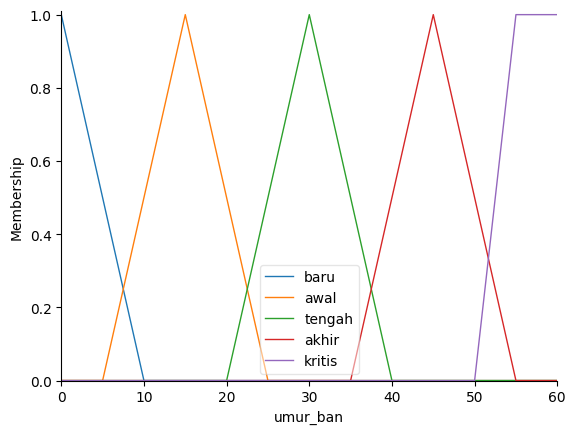

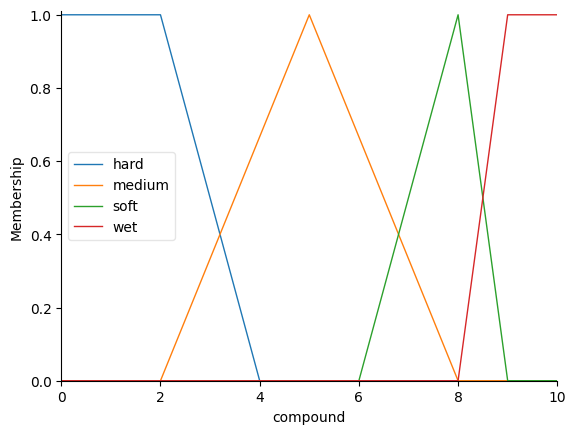

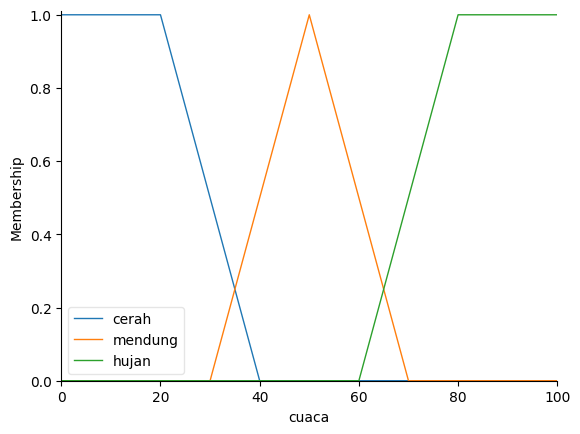

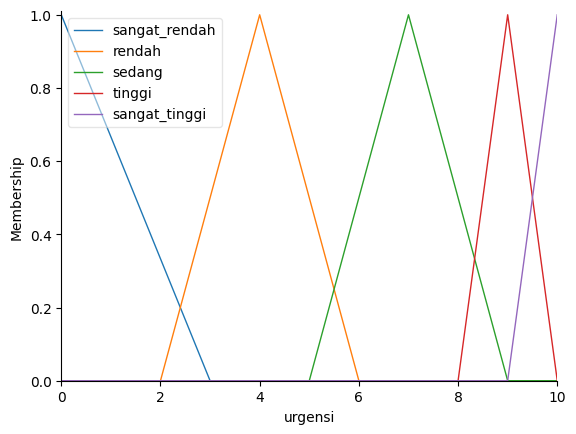

In [66]:
umur_ban.view()
compound.view()
cuaca.view()
urgensi.view()

### Test Cases

Test 1 (Ban Aus/Soft/Cerah): Urgensi = 9.67
Test 2 (Ban Baru/Hard/Hujan): Urgensi = 5.42


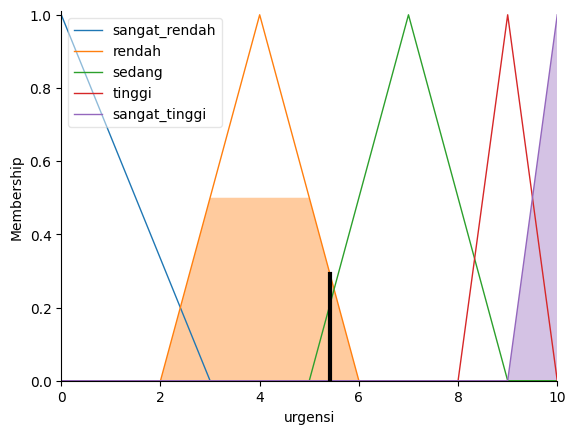

In [67]:
print(f"Test 1 (Ban Aus/Soft/Cerah): Urgensi = {hitung_urgensi(55, 7, 10):.2f}")
print(f"Test 2 (Ban Baru/Hard/Hujan): Urgensi = {hitung_urgensi(20, 1, 90):.2f}")
urgensi.view(sim=pit_advisor)

---
## Modul 2: Bayesian Network (Risk Analyzer)

Modul ini menggunakan **Bayesian Network** untuk menghitung probabilitas terjadinya Safety Car berdasarkan faktor-faktor yang saling mempengaruhi.

### Struktur DAG (Directed Acyclic Graph)

```
    Trek ─────────┐
                  │
    Cuaca ────────┼──► Probabilitas SC
                  │
    Histori SC ───┘
```

### Variabel dan Nilai

- **Trek**: Permanent (0) atau Street (1) - Street circuit lebih berbahaya
- **Cuaca**: Dry (0) atau Wet (1) - Kondisi basah meningkatkan risiko
- **Histori SC**: Low (0), Medium (1), atau High (2) - Berdasarkan data historis sirkuit

### Conditional Probability Table (CPT)

Probabilitas SC dihitung berdasarkan kombinasi ketiga variabel parent. Contoh:
- Permanent + Dry + Low History → P(SC) = 10%
- Street + Wet + High History → P(SC) = 90%

In [68]:
class BayesianSC:
    def __init__(self):
        self.cpt = {
            (0, 0, 0): 0.1, (0, 0, 1): 0.3, (0, 0, 2): 0.5,
            (0, 1, 0): 0.4, (0, 1, 1): 0.6, (0, 1, 2): 0.8,
            (1, 0, 0): 0.3, (1, 0, 1): 0.5, (1, 0, 2): 0.7,
            (1, 1, 0): 0.7, (1, 1, 1): 0.8, (1, 1, 2): 0.9,
        }
        self.edges = [('Trek', 'Probabilitas_SC'), ('Cuaca', 'Probabilitas_SC'), ('Histori_SC', 'Probabilitas_SC')]
    
    def query(self, trek, cuaca, histori):
        if isinstance(trek, str):
            trek = 1 if trek.lower() == 'street' else 0
        if isinstance(cuaca, str):
            cuaca = 1 if cuaca.lower() == 'wet' else 0
        if isinstance(histori, str):
            histori = {'low': 0, 'medium': 1, 'high': 2}.get(histori.lower(), 1)
        p_sc = self.cpt.get((trek, cuaca, histori), 0.5)
        return {'No_SC': 1 - p_sc, 'SC': p_sc}
    
    def get_dag(self):
        G = nx.DiGraph()
        G.add_edges_from(self.edges)
        return G

model = BayesianSC()
print("Bayesian Network initialized successfully.")

Bayesian Network initialized successfully.


### Visualisasi DAG & Test

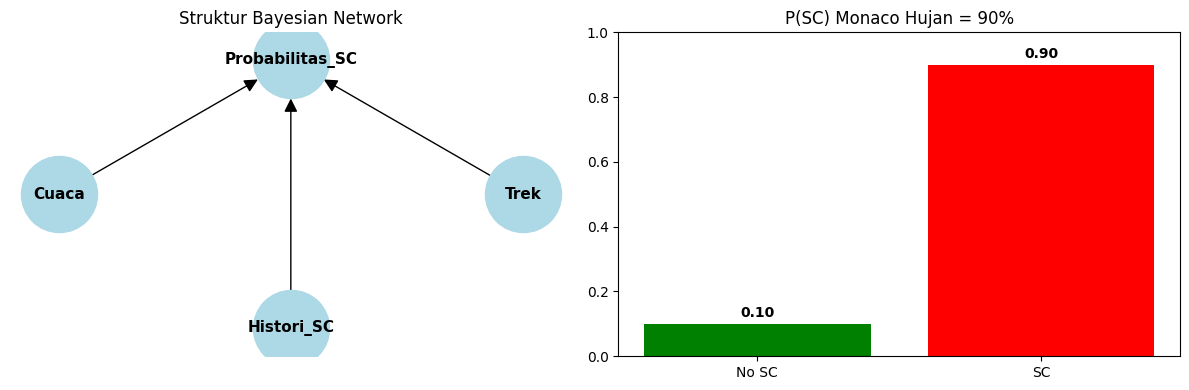

In [69]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

G = model.get_dag()
nx.draw(G, pos=nx.circular_layout(G), ax=axes[0], with_labels=True, 
        node_color='lightblue', node_size=3000, font_size=11, font_weight='bold', arrowsize=20)
axes[0].set_title("Struktur Bayesian Network")

result = model.query('Street', 'Wet', 'High')
axes[1].bar(['No SC', 'SC'], [result['No_SC'], result['SC']], color=['green', 'red'])
axes[1].set_ylim(0, 1)
axes[1].set_title(f"P(SC) Monaco Hujan = {result['SC']:.0%}")
for i, v in enumerate([result['No_SC'], result['SC']]):
    axes[1].text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

---
## Modul 3: First-Order Logic (Validator Regulasi)

Modul ini menggunakan **First-Order Logic (FOL)** dengan Knowledge Base untuk memvalidasi strategi pit stop berdasarkan regulasi FIA Formula 1.

### Regulasi FIA (Article 30)

- **Dry Race**: Wajib menggunakan minimal 2 compound kering berbeda selama balapan
- **Wet Race**: Aturan mandatory compound tidak berlaku jika "Wet Race" dideklarasikan

### Knowledge Base

**Fakta dasar:**
- `IsDry(Soft)`, `IsDry(Medium)`, `IsDry(Hard)`
- `IsWet(Intermediate)`, `IsWet(Wet)`
- `Different(X, Y)` untuk setiap pasangan compound berbeda

**Aturan inferensi:**
1. `Used(x) ∧ IsWet(x) → MandatorySatisfied()` (Exception untuk wet race)
2. `Used(x) ∧ IsDry(x) ∧ Used(y) ∧ IsDry(y) ∧ Different(x,y) → MandatorySatisfied()`

In [70]:
def create_f1_kb():
    kb = FolKB()
    kb.tell(expr('IsDry(Soft)'))
    kb.tell(expr('IsDry(Medium)'))
    kb.tell(expr('IsDry(Hard)'))
    kb.tell(expr('IsWet(Intermediate)'))
    kb.tell(expr('IsWet(Wet)'))
    kb.tell(expr('Used(x) & IsWet(x) ==> MandatorySatisfied()'))
    
    for c1 in ['Soft', 'Medium', 'Hard']:
        for c2 in ['Soft', 'Medium', 'Hard']:
            if c1 != c2:
                kb.tell(expr(f'Different({c1}, {c2})'))
    
    kb.tell(expr('Used(x) & IsDry(x) & Used(y) & IsDry(y) & Different(x, y) ==> MandatorySatisfied()'))
    return kb

def validate_strategy_fol(history_tires, proposed_tire, weather_condition):
    kb = create_f1_kb()
    for tire in history_tires + [proposed_tire]:
        kb.tell(expr(f'Used({tire})'))
    
    if weather_condition == "Wet":
        return True, "Valid - Wet Race declared (mandatory compound suspended)"
    
    result = kb.ask(expr('MandatorySatisfied()'))
    if result is not False:
        return True, "Valid - Regulation satisfied (2 different dry compounds used)"
    return False, "Invalid - Must use at least 2 different dry compounds"

print("FOL Validator initialized successfully.")

FOL Validator initialized successfully.


### Test & Heatmap Validasi

Soft → Soft (Dry): Invalid - Must use at least 2 different dry compounds
Soft → Medium (Dry): Valid - Regulation satisfied (2 different dry compounds used)
Wet → Wet (Wet): Valid - Wet Race declared (mandatory compound suspended)


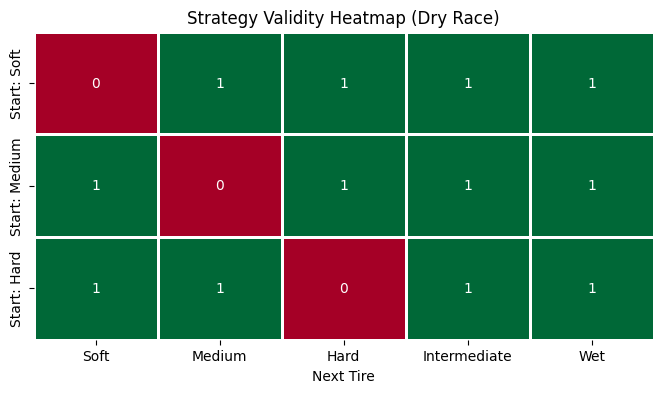

In [71]:
print(f"Soft → Soft (Dry): {validate_strategy_fol(['Soft'], 'Soft', 'Dry')[1]}")
print(f"Soft → Medium (Dry): {validate_strategy_fol(['Soft'], 'Medium', 'Dry')[1]}")
print(f"Wet → Wet (Wet): {validate_strategy_fol(['Wet'], 'Wet', 'Wet')[1]}")

tires = ['Soft', 'Medium', 'Hard', 'Intermediate', 'Wet']
histories = ['Soft', 'Medium', 'Hard']
matrix = np.array([[1 if validate_strategy_fol([h], t, "Dry")[0] else 0 for t in tires] for h in histories])

plt.figure(figsize=(8, 4))
sns.heatmap(matrix, annot=True, cmap="RdYlGn", xticklabels=tires, 
            yticklabels=[f"Start: {h}" for h in histories], cbar=False, linewidths=1)
plt.title("Strategy Validity Heatmap (Dry Race)")
plt.xlabel("Next Tire")
plt.show()

---
## Modul 4: Race Simulator (Decision Engine)

Modul ini mengintegrasikan ketiga modul sebelumnya untuk melakukan simulasi strategi balapan menggunakan **data telemetri nyata dari FastF1**.

### Fitur

- **Data Real**: Menggunakan data lap-by-lap dari balapan sesungguhnya
- **Perbandingan**: Membandingkan keputusan AI vs pit stop aktual
- **Visualisasi**: Dashboard untuk melihat tren urgensi sepanjang balapan

### Logika Keputusan

- Urgensi > 7.5 → BOX BOX (Critical)
- Urgensi >= 4.5 → BOX BOX (Strategic)
- Safety Car aktif → BOX BOX (SC)
- Lainnya → STAY OUT

In [72]:
print("Loading Race Data (Spanish GP 2023)...")
session = fastf1.get_session(2023, 'Spain', 'R')
session.load()

driver = 'VER'
laps = session.laps.pick_driver(driver)
print(f"Data loaded successfully: {driver} - {len(laps)} laps")

Loading Race Data (Spanish GP 2023)...
Data loaded successfully: VER - 66 laps
Data loaded successfully: VER - 66 laps


In [73]:
class DecisionEngine:
    def __init__(self, driver_laps):
        self.laps = driver_laps.reset_index(drop=True)
        self.history_tires = []
        self.current_tire = None
        self.recommendations = []
        
    def run_simulation(self):
        print("\n--- Race Strategy Simulation ---")
        
        for _, row in self.laps.iterrows():
            lap = int(row['LapNumber'])
            tire_life = row['TyreLife']
            compound = row['Compound']
            track_status = str(row.get('TrackStatus', '1'))
            is_sc = '4' in track_status or '6' in track_status
            
            if self.current_tire != compound:
                if self.current_tire:
                    self.history_tires.append(self.current_tire)
                self.current_tire = compound
            
            comp_val = COMPOUND_MAP.get(compound.upper(), 5)
            urgency = 10.0 if is_sc else hitung_urgensi(tire_life, comp_val, 10)
            
            if urgency > THRESHOLD_CRITICAL:
                decision = "BOX (Critical)"
            elif urgency >= THRESHOLD_STRATEGIC:
                decision = "BOX (Strategic)"
            elif is_sc:
                decision = "BOX (SC)"
            else:
                decision = "STAY OUT"
            
            actual_pit = not pd.isna(row['PitInTime'])
            self.recommendations.append({'Lap': lap, 'Urgency': urgency, 'Decision': decision, 'ActualPit': actual_pit})
            
            if actual_pit or urgency > 6.0:
                print(f"Lap {lap:2d} | {compound} ({tire_life:.0f}L) | Urgency: {urgency:.1f} | AI: {decision} | Actual: {'PIT' if actual_pit else '-'}")
        
        print("--- Simulation Complete ---")
        return pd.DataFrame(self.recommendations)

engine = DecisionEngine(laps)
results_df = engine.run_simulation()


--- Race Strategy Simulation ---
Lap 24 | MEDIUM (24L) | Urgency: 6.3 | AI: BOX (Strategic) | Actual: -
Lap 25 | MEDIUM (25L) | Urgency: 7.0 | AI: BOX (Strategic) | Actual: -
Lap 26 | MEDIUM (26L) | Urgency: 7.0 | AI: BOX (Strategic) | Actual: PIT
Lap 50 | HARD (24L) | Urgency: 6.3 | AI: BOX (Strategic) | Actual: -
Lap 51 | HARD (25L) | Urgency: 7.0 | AI: BOX (Strategic) | Actual: -
Lap 52 | HARD (26L) | Urgency: 7.0 | AI: BOX (Strategic) | Actual: PIT
--- Simulation Complete ---
--- Simulation Complete ---


### Race Dashboard

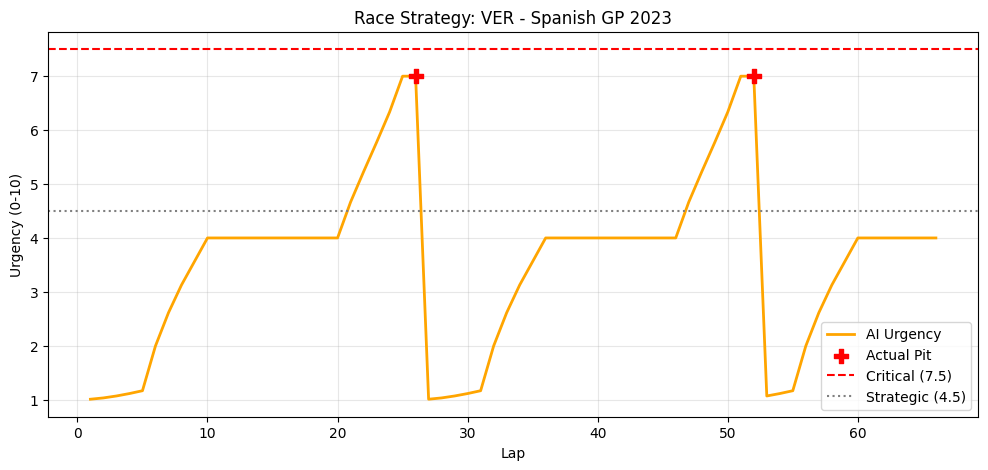

In [74]:
plt.figure(figsize=(12, 5))
sns.lineplot(data=results_df, x='Lap', y='Urgency', color='orange', linewidth=2, label='AI Urgency')

actual_pits = results_df[results_df['ActualPit']]
plt.scatter(actual_pits['Lap'], actual_pits['Urgency'], color='red', s=100, marker='P', label='Actual Pit', zorder=5)

plt.axhline(y=THRESHOLD_CRITICAL, color='red', linestyle='--', label=f'Critical ({THRESHOLD_CRITICAL})')
plt.axhline(y=THRESHOLD_STRATEGIC, color='grey', linestyle=':', label=f'Strategic ({THRESHOLD_STRATEGIC})')
plt.title(f"Race Strategy: {driver} - Spanish GP 2023")
plt.xlabel("Lap")
plt.ylabel("Urgency (0-10)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

---
## Modul 5: Real-time Strategy Interface

Modul ini menyediakan interface untuk input manual kondisi balapan saat ini dan mendapatkan rekomendasi strategi secara instan.

### Fitur

- **Weather API Integration**: Mengambil data cuaca real-time dari Open-Meteo API
- **Circuit Database**: Koordinat 24 sirkuit F1 dari file `circuit coordinate.csv`
- **Combined Analysis**: Menggabungkan output dari Modul 1, 2, dan 3

### Parameter Input

- **Circuit** (String): 'Monaco', 'Silverstone', 'Spa-Francorchamps', dll.
- **Tire Age** (Integer): 0-60 laps
- **Compound** (String): 'SOFT', 'MEDIUM', 'HARD', 'INTER', 'WET'
- **Track Type** (String): 'Street' atau 'Permanent'
- **SC History** (String): 'Low', 'Medium', 'High'
- **Is SC Active** (Boolean): True / False
- **Tire History** (List): ['SOFT'], ['SOFT', 'MEDIUM'], dll.

In [75]:
def get_weather(lat, lon):
    try:
        url = f"https://api.open-meteo.com/v1/forecast?latitude={lat}&longitude={lon}&minutely_15=precipitation&current=cloud_cover&forecast_days=1"
        data = requests.get(url).json()
        cloud = data.get('current', {}).get('cloud_cover', 0)
        precip = data.get('minutely_15', {}).get('precipitation', [0, 0])
        
        if precip[0] > 0.1:
            print(f"   [WEATHER] Rain detected! Precipitation: {precip[0]}mm")
            return 95
        elif precip[1] > 0.1:
            print(f"   [WEATHER] Warning: Rain incoming in 15 mins!")
            return 85
        print(f"   [WEATHER] Dry conditions. Cloud cover: {cloud}%")
        return cloud
    except:
        return 10

class RealTimeAdvisor:
    def __init__(self):
        self.history_tires = []
        
    def set_history(self, tires):
        self.history_tires = [t.upper() for t in tires]
        
    def get_recommendation(self, tire_age, compound, weather, track_type, sc_history, is_sc=False):
        print(f"\n{'='*50}")
        print(f"REAL-TIME STRATEGY ANALYSIS")
        print(f"{'='*50}")
        print(f"Tire: {compound} ({tire_age} laps) | Weather: {weather}% | Track: {track_type}")
        print(f"{'-'*50}")
        
        comp_val = COMPOUND_MAP.get(compound.upper(), 5)
        urgency = 10.0 if is_sc else hitung_urgensi(tire_age, comp_val, weather)
        print(f"[1] Urgency Score (Fuzzy): {urgency:.1f}/10")
        
        cuaca_str = 'Wet' if weather > 50 else 'Dry'
        sc_prob = model.query(track_type, cuaca_str, sc_history)['SC']
        print(f"[2] SC Probability (Bayesian): {sc_prob:.0%}")
        
        next_tire = "Medium" if compound.upper() != "MEDIUM" else "Hard"
        _, msg = validate_strategy_fol(self.history_tires, next_tire, cuaca_str)
        print(f"[3] Regulation Check (FOL): {msg}")
        
        if urgency > THRESHOLD_CRITICAL:
            decision, reason = "BOX BOX (Critical)", "Tire urgency is critically high"
        elif is_sc:
            decision, reason = "BOX BOX (SC)", "Safety Car is active - cheap pit stop"
        elif urgency >= THRESHOLD_STRATEGIC:
            decision, reason = "BOX BOX (Strategic)", "Strategic pit window is open"
        elif sc_prob > 0.6:
            decision, reason = "BOX BOX (Gamble)", "High SC probability - opportunistic pit"
        else:
            decision, reason = "STAY OUT", "Conditions are optimal - continue racing"
        
        print(f"{'-'*50}")
        print(f"RECOMMENDATION: {decision}")
        print(f"Reason: {reason}")
        print(f"{'='*50}")
        return {'Urgency': urgency, 'SC_Prob': sc_prob, 'Decision': decision}

advisor = RealTimeAdvisor()
print("Real-time Advisor initialized successfully.")

Real-time Advisor initialized successfully.


Available circuits: ['Melbourne', 'Shanghai', 'Suzuka', 'Sakhir', 'Jeddah', 'Miami', 'Montreal', 'Monaco', 'Barcelona-Catalunya', 'Spielberg', 'Silverstone', 'Spa-Francorchamps', 'Budapest', 'Zandvoort', 'Monza', 'Madrid', 'Baku', 'Singapore', 'Austin', 'Mexico City', 'Sao Paulo', 'Las Vegas', 'Lusail', 'Yas Marina']

Selected circuit: Monaco (Lat: 43.7347, Lon: 7.4205)
   [WEATHER] Dry conditions. Cloud cover: 83%

REAL-TIME STRATEGY ANALYSIS
Tire: MEDIUM (28 laps) | Weather: 83% | Track: Street
--------------------------------------------------
[1] Urgency Score (Fuzzy): 7.6/10
[2] SC Probability (Bayesian): 90%
[3] Regulation Check (FOL): Valid - Wet Race declared (mandatory compound suspended)
--------------------------------------------------
RECOMMENDATION: BOX BOX (Critical)
Reason: Tire urgency is critically high
   [WEATHER] Dry conditions. Cloud cover: 83%

REAL-TIME STRATEGY ANALYSIS
Tire: MEDIUM (28 laps) | Weather: 83% | Track: Street
--------------------------------------

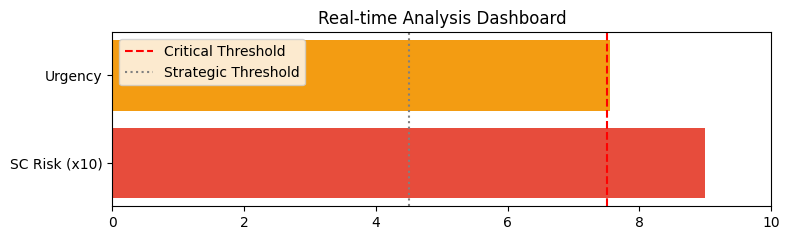

In [76]:
INPUT_CIRCUIT = 'Monaco'
INPUT_TIRE_AGE = 28
INPUT_COMPOUND = 'MEDIUM'
INPUT_TRACK = 'Street'
INPUT_SC_HIST = 'High'
INPUT_IS_SC = False
INPUT_HISTORY = ['SOFT']

print(f"Available circuits: {list(CIRCUIT_COORDS.keys())}\n")

if INPUT_CIRCUIT in CIRCUIT_COORDS:
    lat, lon = CIRCUIT_COORDS[INPUT_CIRCUIT]
    print(f"Selected circuit: {INPUT_CIRCUIT} (Lat: {lat:.4f}, Lon: {lon:.4f})")
    INPUT_WEATHER = get_weather(lat, lon)
else:
    print(f"Circuit not found, using default weather value")
    INPUT_WEATHER = 10

advisor.set_history(INPUT_HISTORY)
result = advisor.get_recommendation(INPUT_TIRE_AGE, INPUT_COMPOUND, INPUT_WEATHER, INPUT_TRACK, INPUT_SC_HIST, INPUT_IS_SC)

plt.figure(figsize=(8, 2.5))
plt.barh(['SC Risk (x10)', 'Urgency'], [result['SC_Prob']*10, result['Urgency']], color=['#e74c3c', '#f39c12'])
plt.axvline(x=THRESHOLD_CRITICAL, color='red', linestyle='--', label='Critical Threshold')
plt.axvline(x=THRESHOLD_STRATEGIC, color='grey', linestyle=':', label='Strategic Threshold')
plt.xlim(0, 10)
plt.legend()
plt.title("Real-time Analysis Dashboard")
plt.tight_layout()
plt.show()